# LSTM

#### To get autocomplete working for python 3.7 in local jupyter notebooks

In [2]:
%config Completer.use_jedi = False

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.
  """Entry point for launching an IPython kernel.


#### Tell colab what version to use

In [3]:
%tensorflow_version 2.x

## Import Libraries

In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Build generator for dataset

The generator returns:
A random number sequence with a variable length

The context, consisting of two digits

The  label, which is [1,0] if the first digits appears more often in the sequence, [0,1] if the second digit appears more often and [1,1] when both digits appear equally often

And a parameter denoting the actual length of the sequence


In [5]:
SEQ_MAX = 20

def seq_gen():
    while True:
        seq_len = np.random.randint(1,SEQ_MAX)
        seq = np.random.randint(10, size=seq_len)
        context = np.random.randint(10, size=2)
        n1 = np.sum(seq==context[0])
        n2 = np.sum(seq==context[1])
        label = [float(n1>=n2),float(n2>=n1)]
        yield seq, context, label, seq_len


# Generate the dataset

In [6]:
dataset = tf.data.Dataset.from_generator(seq_gen,
                                         output_types=(tf.int32,tf.int32,tf.float32,tf.int32))

# Inspect the dataset

In [7]:
for elem in dataset.take(1):
    print(f'Sequence:\n{elem[0]}')
    print(f'Context:\n{elem[1]}')
    print(f'Label:\n{elem[2]}')    
    print(f'Length:\n{elem[3]}')

Sequence:
[3 1 9 1 5 7 1 1 8 8 5 6 4]
Context:
[0 3]
Label:
[0. 1.]
Length:
13


# Preprocess the data

The create_input function concatinates the context with each element of the sequence to create our input vector for the LSTM.

This input is also padded with zeros, so that all input vectors are of the same size.

In [8]:
def create_input(seq,context,length):
    t=tf.constant(0)
    x=tf.TensorArray(tf.float32, size=SEQ_MAX, dynamic_size=False)
    while tf.less(t,length):
        x = x.write(t,tf.concat((tf.one_hot(seq[t],10), tf.reshape(tf.one_hot(context, 10), (20,))), 0))
        t = t+1
    return x.stack()

In [9]:
for seq,con,_,l in dataset.take(1):
    print(seq,con)
    print(create_input(seq,con,l))

tf.Tensor([7 2 9 1 5 6 4 1 4 1 4 1 5 1 9], shape=(15,), dtype=int32) tf.Tensor([4 1], shape=(2,), dtype=int32)
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 

In [10]:
BATCH_SIZE = 64

# Create Datasets and make sure minibatches all have same size
train_dataset_unprocessed = dataset.take(1000*BATCH_SIZE)
test_dataset_unprocessed = dataset.take(100*BATCH_SIZE)

# One-hot encode the data
train_dataset = train_dataset_unprocessed.map(lambda seq,context,lbl,l:
                                              (create_input(seq,context,l),
                                               lbl,
                                               l
                                              ),
                                              num_parallel_calls=tf.data.experimental.AUTOTUNE)

test_dataset = test_dataset_unprocessed.map(lambda seq,context,lbl,l:
                                            (create_input(seq,context,l),
                                             lbl,
                                             l
                                            ),
                                            num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Cache the preprocessed datasets
train_dataset = train_dataset.cache()
test_dataset = test_dataset.cache()

# Shuffle the data
train_dataset = train_dataset.shuffle(BATCH_SIZE)
test_dataset = test_dataset.shuffle(BATCH_SIZE)

# Create minibatches
train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Prefetch the data
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [11]:
for seq,lbl,l in train_dataset.take(1):
    for t in range(SEQ_MAX):
        print(seq[:,t],lbl,l)
        break

tf.Tensor(
[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]], shape=(64, 30), dtype=float32) tf.Tensor(
[[0. 1.]
 [1. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 1.]
 [1. 0.]
 [1. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]
 [1. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 1.]
 [0. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 0.]
 [0. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [0. 1.]
 [1. 0.]
 [1. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 1.]
 [1. 0.]
 [1. 0.]
 [1. 1.]
 [0. 1.]
 [1. 0.]
 [1. 1.]], shape=(64, 2), dtype=float32) tf.Tensor(
[17  6 19  2 19 13 11  4 11  7 16 16 10 11 17 13  9  3  1  9 17  7 16  8
 15 10 14 13  5  4  4  2 16 18 18 17  1 15  8  4 17  3 10  3  2 19  2  3
  5 14  6  4  7 19  4 10 

# Define LSTM cell

In [12]:
from tensorflow.keras import Model

class LSTM_cell(Model):
    def __init__(self, unit_size):
        super(LSTM_cell, self).__init__()
        self.forget_gate = tf.keras.layers.Dense(units=unit_size,
                                                 activation='sigmoid',
                                                 bias_initializer='ones',
                                                 name='Forget_gate'
                                                )
        
        self.input_gate = tf.keras.layers.Dense(units=unit_size,
                                                activation='sigmoid',
                                                name='Input_gate'
                                               )
        
        self.candidates = tf.keras.layers.Dense(units=unit_size,
                                                activation='tanh',
                                                name='candidate_layer'
                                                )
        
        self.output_gate = tf.keras.layers.Dense(units=unit_size,
                                                 activation='sigmoid',
                                                 name='Output_gate'
                                                )
    
    def call(self, x_t, states):
        h_t, c_t = states
        cell_input = tf.concat((x_t,h_t),1)

        # Computing the filter
        f_t = self.forget_gate(cell_input)
        i_t = self.input_gate(cell_input)
        candidates = self.candidates(cell_input)
        o_t = self.output_gate(cell_input)
        
        # Computing the new states
        c_t = f_t*c_t + i_t*candidates
        h_t = o_t*tf.nn.tanh(c_t)
        
        return (h_t,c_t)

# Inspect LSTM cell

In [13]:
cell = LSTM_cell(50)
c = cell(tf.ones((BATCH_SIZE,10)),
         (tf.zeros((BATCH_SIZE,50)),tf.zeros((BATCH_SIZE,50)))
        )
cell.summary()

Model: "lstm_cell"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Forget_gate (Dense)          multiple                  3050      
_________________________________________________________________
Input_gate (Dense)           multiple                  3050      
_________________________________________________________________
candidate_layer (Dense)      multiple                  3050      
_________________________________________________________________
Output_gate (Dense)          multiple                  3050      
Total params: 12,200
Trainable params: 12,200
Non-trainable params: 0
_________________________________________________________________


# Define LSTM

In [14]:
class LSTM(Model):
    def __init__(self, unit_size):
        super(LSTM, self).__init__()
        self.unit_size = unit_size
        
        self.LSTMcell = LSTM_cell(self.unit_size)

        self.readin_layer = tf.keras.layers.Dense(units=10,
                                                  activation=None,
                                                  name='ReadIn_layer'
                                                 )
        
        # We use a sigmoid activation to treat every class independend
        self.output_layer = tf.keras.layers.Dense(units=2,
                                                  activation='sigmoid',
                                                  name='Output_layer'
                                                 )
          
    def call(self, seq):
        steps = tf.constant(SEQ_MAX)
        t = tf.constant(0)
        # Store the outputs of each timestep in a TensorArray
        # We later need the outputs of different timesteps for the different sequence lengths
        outputs = tf.TensorArray(tf.float32, size=SEQ_MAX)
        
        x = self.readin_layer(seq)

        # First timestep; reset cell states
        h_t = tf.zeros((BATCH_SIZE,self.unit_size))
        c_t = tf.zeros((BATCH_SIZE,self.unit_size))

        h_t, c_t = self.LSTMcell(x[:,t,:],
                                   (h_t,c_t)
                                  )
        output = self.output_layer(h_t)
        outputs = outputs.write(0,output)
        t += 1
        
        # Use tensorflow conditional tf.less for graph mode
        while tf.less(t, steps):
            h_t, c_t = self.LSTMcell(x[:,t,:],
                                       (h_t, c_t)
                                      )
            output = self.output_layer(h_t)
            outputs = outputs.write(t,output)
            t += 1
        
        # Transpose the TensorArray to get shape (BATCH_SIZE, Timesteps, output_size)
        lstm_out = tf.transpose(outputs.stack(),perm=[1,0,2])
        return lstm_out

# Inspect LSTM

In [15]:
lstm = LSTM(50)
lstm_out = lstm(tf.ones((BATCH_SIZE,SEQ_MAX,30)))
lstm.summary()
lstm_out

Model: "lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_cell_1 (LSTM_cell)      multiple                  12200     
_________________________________________________________________
ReadIn_layer (Dense)         multiple                  310       
_________________________________________________________________
Output_layer (Dense)         multiple                  102       
Total params: 12,612
Trainable params: 12,612
Non-trainable params: 0
_________________________________________________________________


<tf.Tensor: shape=(64, 20, 2), dtype=float32, numpy=
array([[[0.5114979 , 0.5296736 ],
        [0.51794654, 0.5449942 ],
        [0.5190605 , 0.55525774],
        ...,
        [0.46828583, 0.5972117 ],
        [0.4665308 , 0.59720504],
        [0.46499324, 0.5972482 ]],

       [[0.5114979 , 0.5296736 ],
        [0.51794654, 0.5449942 ],
        [0.5190605 , 0.55525774],
        ...,
        [0.46828583, 0.5972117 ],
        [0.4665308 , 0.59720504],
        [0.46499324, 0.5972482 ]],

       [[0.5114979 , 0.5296736 ],
        [0.51794654, 0.5449942 ],
        [0.5190605 , 0.55525774],
        ...,
        [0.46828583, 0.5972117 ],
        [0.4665308 , 0.59720504],
        [0.46499324, 0.5972482 ]],

       ...,

       [[0.5114979 , 0.5296736 ],
        [0.51794654, 0.5449942 ],
        [0.5190605 , 0.55525774],
        ...,
        [0.46828583, 0.5972117 ],
        [0.4665308 , 0.59720504],
        [0.46499324, 0.5972482 ]],

       [[0.5114979 , 0.5296736 ],
        [0.51794654, 0.5

# Define the training process

#### Function to plot the models performance

In [16]:
from IPython.display import clear_output

def visualize_progress(num_epochs, epoch, train_losses, test_losses, train_accs, test_accs):
    clear_output(wait=True)
    fig = plt.figure(figsize=(15,10))
    plt.subplot(2,1,1)
    plt.xlim((0,num_epochs))
    plt.plot(train_losses,label='Training')
    plt.plot(test_losses,label='Test')
    plt.ylabel('Loss',fontsize=24)
    plt.xlabel('Epochs',fontsize=24)
    plt.title(f'Epoch: {epoch+1}', fontweight='bold', fontsize=30)
    plt.xticks(np.arange(0,num_epochs,2))
    plt.legend()
    plt.subplot(2,1,2)
    plt.xlim((0,num_epochs))
    plt.plot(train_accs,label='Training')
    plt.plot(test_accs,label='Test')    
    plt.axhline(0.95,xmax=num_epochs,c='g',ls='--')
    plt.ylabel('Accuracy',fontsize=24)
    plt.xlabel('Epochs',fontsize=24)
    plt.xticks(np.arange(0,num_epochs,2))
    plt.legend()
    fig.tight_layout()
    plt.show() 

In [17]:
def train_model(model, train_dataset, test_dataset, loss_function, optimizer, num_epochs):
    running_average_factor = 0.95

    # Initialize lists for later visualization.
    train_losses = []
    train_accuracies = []

    test_losses = []
    test_accuracies = []

    # Testing model performance on train and test data before learning
    train_loss, train_accuracy = test(model, train_dataset, loss_function)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    test_loss, test_accuracy = test(model, test_dataset, loss_function)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    # Train loop for num_epochs epochs.
    for epoch in range(num_epochs):
            
        # Training
        running_average_loss = 0
        running_average_accuracy = 0
        for seq, lbl, length in train_dataset:
            train_loss, train_accuracy = train_step(model, seq, lbl, length, loss_function, optimizer)
            running_average_loss = running_average_factor * running_average_loss  + (1 - running_average_factor) * train_loss
            running_average_accuracy = running_average_factor * running_average_accuracy + (1 - running_average_factor) * train_accuracy

        train_losses.append(running_average_loss.numpy())
        train_accuracies.append(running_average_accuracy.numpy())

        # Testing
        test_loss, test_accuracy = test(model, test_dataset, loss_function)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
        visualize_progress(num_epochs, epoch, train_losses, test_losses, train_accuracies, test_accuracies)
            
        # Display loss and accuracy for current epoch    
        print('Epoch: __ ' + str(epoch))
        print('Train loss: ',running_average_loss.numpy())
        print('Test loss: ',test_loss)
        print('Train accuracy: ',running_average_accuracy.numpy())
        print('Test accuracy: ',test_accuracy)
        
    model_performance = {
        "train_loss": train_losses,
        "test_loss": test_losses,
        "train_accuracy": train_accuracies,
        "test_accuracy": test_accuracies,
    }
    return model_performance

# Define training and testing

In [18]:
@tf.function
def train_step(model, seq, target, length, loss_function, optimizer):
    with tf.GradientTape() as tape:
        prediction = model(seq)
        # Get last prediction at the end of the sequence (denoted by length)
        last_pred = tf.gather(prediction,length-1,axis=1,batch_dims=1)        
        loss = loss_function(target, last_pred)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.equal(target,1), tf.greater(last_pred,0.5)), tf.float32))
    return loss, accuracy

@tf.function
def performance_calc(model, seq, target, length, loss_function):
    prediction = model(seq)
    last_pred = tf.gather(prediction,length-1,axis=1,batch_dims=1)
    loss = loss_function(target, last_pred)
    accuracy =  tf.reduce_mean(tf.cast(tf.equal(tf.equal(target,1), tf.greater(last_pred,0.5)), tf.float32))
    return loss, accuracy

def test(model, test_data, loss_function):
    # Test over complete test data
    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for seq, target, length in test_data:
        loss, accuracy = performance_calc(model, seq, target, length, loss_function)
        test_loss_aggregator.append(loss.numpy())
        test_accuracy_aggregator.append(accuracy.numpy())

    test_loss = np.mean(test_loss_aggregator)
    test_accuracy = np.mean(test_accuracy_aggregator)

    return test_loss, test_accuracy

# Train LSTM

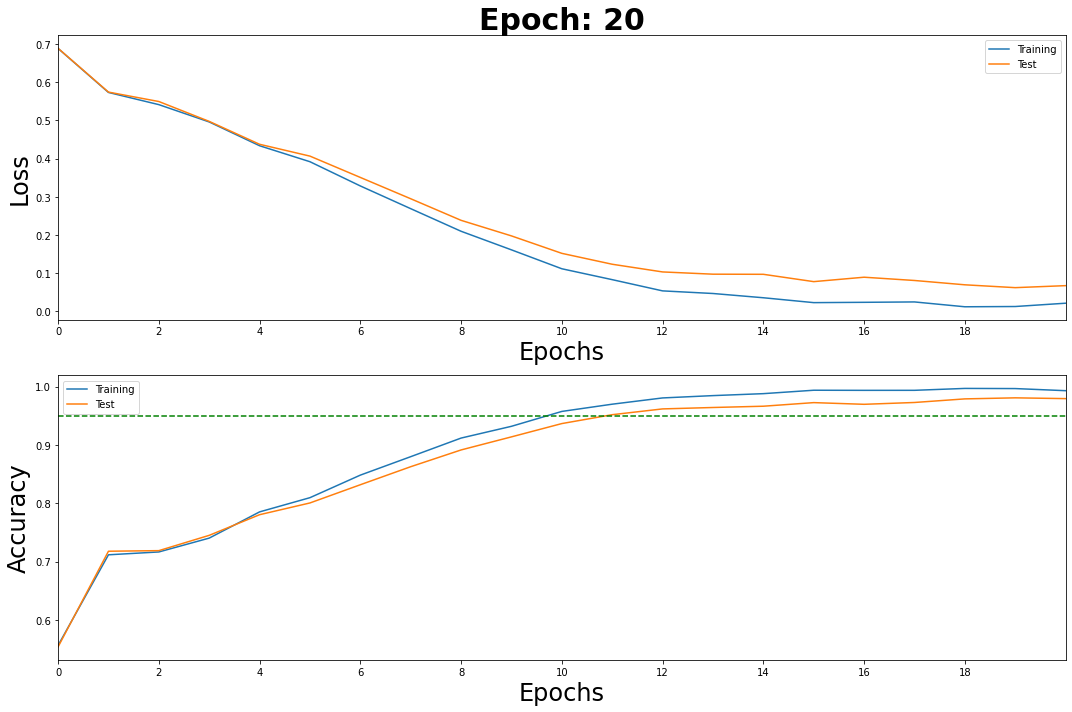

Epoch: __ 19
Train loss:  0.021143952
Test loss:  0.06714176
Train accuracy:  0.99305475
Test accuracy:  0.97945315
CPU times: user 11min 19s, sys: 1min 1s, total: 12min 21s
Wall time: 8min 34s


In [19]:
%%time
tf.keras.backend.clear_session()

learning_rate = 0.001
hidden_size = 500
epochs = 20

# Initialize the loss
# We use BinaryCrossentropy to treat both classes ('digit one appears more often' and 'digit two appears more often')
# independend as a binary classification
loss_function = tf.keras.losses.BinaryCrossentropy()

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize model
lstm = LSTM(hidden_size)
train_model(
    model = lstm,
    train_dataset = train_dataset,
    test_dataset = test_dataset,
    num_epochs = epochs,
    loss_function = loss_function,
    optimizer = optimizer
)

In [20]:
lstm.summary()

Model: "lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_cell (LSTM_cell)        multiple                  1022000   
_________________________________________________________________
ReadIn_layer (Dense)         multiple                  310       
_________________________________________________________________
Output_layer (Dense)         multiple                  1002      
Total params: 1,023,312
Trainable params: 1,023,312
Non-trainable params: 0
_________________________________________________________________


# Test one batch of sequences

In [21]:
for seq_batch,lbl,_ in test_dataset.take(1):
    pred_batch = lstm(seq_batch)

    for i,seq in enumerate(seq_batch):
        seq = seq_batch[i].numpy()
        seq = seq.reshape(-1,3,10)
        context = seq[0,1:]
        seq = seq[:,0]
        
        pred = pred_batch[i].numpy()[-1]

        print('Context: ',np.argwhere(context)[:,1])
        print('Sequence: ',np.argwhere(seq)[:,1])
        print('Prediction: ',pred)
        print('Label: ', lbl[i].numpy())        
        print()

Context:  [8 5]
Sequence:  [0 0 3 7 5 3 8 7 8 0 3 0 0 2 8 9]
Prediction:  [1.0000000e+00 2.6904234e-05]
Label:  [1. 0.]

Context:  [3 1]
Sequence:  [2 3 7 1 6 1 5 8 2 3 1 5 0]
Prediction:  [0.4717921  0.99960285]
Label:  [0. 1.]

Context:  [9 0]
Sequence:  [7 5 1 2 3 7 4 2]
Prediction:  [0.99998605 0.02750772]
Label:  [1. 1.]

Context:  [2 5]
Sequence:  [3 2 7 4]
Prediction:  [1.000000e+00 8.958318e-06]
Label:  [1. 0.]

Context:  [7 5]
Sequence:  [7 0 1 7 8 1 5 3 6 4 5 1 8 2 8 6 6]
Prediction:  [0.779714   0.99973613]
Label:  [1. 1.]

Context:  [9 8]
Sequence:  [8 1 1 3 8 2 3 3 4 7 1 1 5 5 2]
Prediction:  [8.694939e-07 1.000000e+00]
Label:  [0. 1.]

Context:  [5 5]
Sequence:  [2 2 2 3 7 2 7 9 6 1 8 6 8 9]
Prediction:  [0.9999995 0.9999999]
Label:  [1. 1.]

Context:  [3 4]
Sequence:  [8 9 8 4 1 2 1]
Prediction:  [0.8477953 0.9989851]
Label:  [0. 1.]

Context:  [9 1]
Sequence:  [9 7 5 2 1 7 2 2]
Prediction:  [0.0096623 0.9999944]
Label:  [1. 1.]

Context:  [4 5]
Sequence:  [7 5 2]
Predic